#Анализ тональности

###Импорты

In [124]:
%matplotlib inline

import json
import math

import numpy
import matplotlib.pyplot as plot

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

### Лемматизатор

In [189]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import string
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

###Функция для F1 меры

In [25]:
def f1_measure(P,R):
    return [2*x*y/(x+y) for x,y in zip(P, R)]

###Чтение файлов, bag of words, множество ответов

In [122]:
with open('/Users/ermakovpetr/projects/posneg/pos_reviews.json') as data_file:    
    data_pos = json.load(data_file)
with open('/Users/ermakovpetr/projects/posneg/neg_reviews.json') as data_file:    
    data_neg = json.load(data_file)

pos_texts = data_pos.keys()
neg_texts = data_neg.keys()
all_texts = pos_texts + neg_texts

N_POS_TEXTS = len(pos_texts)
N_NEG_TEXTS = len(neg_texts)
target = [1]*N_POS_TEXT + [0]*N_NEG_TEXT

###Матрица частотности

In [27]:
count_vect = CountVectorizer()
temp_matrix = count_vect.fit_transform(all_texts)
matrix_counts = temp_matrix.toarray()

####без стоп слов

In [187]:
count_vect_without_stopwords = CountVectorizer(stop_words='english')
matrix_counts_without_stopwords = count_vect_without_stopwords.fit_transform(all_texts).toarray()

####с лемматизатором

In [190]:
count_vect_with_lemm = CountVectorizer(tokenizer=tokenize)
matrix_counts_with_lemm = count_vect_with_lemm.fit_transform(all_texts).toarray()

####без стопслов с лемматизатором

In [191]:
count_vect_with_lemm_without_stopwords = CountVectorizer(stop_words='english', tokenizer=tokenize)
matrix_counts_with_lemm_without_stopwords = count_vect_with_lemm_without_stopwords.fit_transform(all_texts).toarray()

###Бинарная матрица встречаемости

In [28]:
count_vect_bin = CountVectorizer(binary=True)
matrix_counts_bin = count_vect_bin.fit_transform(all_texts).toarray()

###TF-IDF матрица

In [29]:
tfidf_transformer = TfidfTransformer()
matrix_tfidf = tfidf_transformer.fit_transform(temp_matrix).toarray()

###Relevance Frequency

In [137]:
def get_after_rf_matrix(in_matrix, in_matrix_bin, IN_N_POS_TEXTS, IN_N_NEG_TEXTS, out_n_features):
    '''first text in all matrix must be positive'''
    pos_rf_prepare = in_matrix_bin[:IN_N_POS_TEXTS].sum(axis=0) 
    neg_rf_prepare = in_matrix_bin[IN_N_POS_TEXTS:].sum(axis=0)
    pos_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(pos_rf_prepare, neg_rf_prepare)])
    neg_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(neg_rf_prepare, pos_rf_prepare)])
    l_pos = pos_rf.argsort()[-out_n_features//2:]
    l_neg = neg_rf.argsort()[-out_n_features//2:]
    return (in_matrix.transpose()[list(set(l_pos) | set(l_neg))]).transpose()

###Кросс-валидация

In [36]:
def cross_valid(matrix_counts, target, test_size=0.3, random_state=0):
    X_train, X_test, Y_train, Y_test = train_test_split(matrix_counts, target, test_size=0.3, random_state=0)
    return (X_train, X_test, Y_train, Y_test)

###Функции для рисования Recall-Precision и ROC кривой

In [117]:
def rp_curve(title, Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:,1])
    plot.plot(recall, precision, label='R-P '+label);
    plot.plot(recall, f1_measure(precision, recall), label='F1 '+label)
    plot.xlabel('Recall'); plot.ylabel('Precision'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);

def roc_curve(title, Y_test, predicted, label='?'):
    fpr, tpr, _ = metrics.roc_curve(Y_test, predicted[:,1])
    plot.plot(fpr, tpr, label=label);
    plot.xlabel('False Positive'); plot.ylabel('True Positive'); plot.title(title)
    plot.legend(bbox_to_anchor=(1, 1), loc=2); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    print 'Logistic Regression (', label, ') AUC = ', metrics.auc(fpr, tpr)

###Логистическая регрессия

In [110]:
def logistic_reg(X_train, X_test, Y_train, **kwargs):
    model_logistic = LogisticRegression(**kwargs)
    model_logistic.fit(X_train, Y_train)
    predicted = model_logistic.predict_proba(X_test)
    return predicted

###Деление выборки

In [111]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)

###Логистическая регрессия на всех данных

In [112]:
logreg_1_predicted = logistic_reg(X_train, X_test, Y_train)

###Логистическая регрессия на всех данных, penalty='l1'

In [113]:
logreg_2_predicted = logistic_reg(X_train, X_test, Y_train, penalty='l1')

###Сравнения логистической регрессии

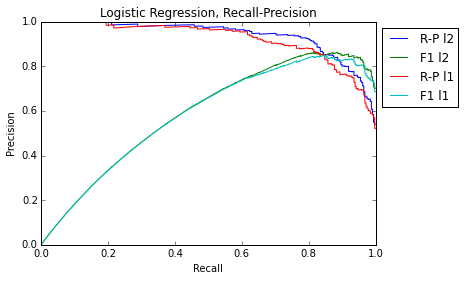

In [118]:
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='l2')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_2_predicted, label='l1')

Logistic Regression ( l2 ) AUC =  0.931306706992
Logistic Regression ( l1 ) AUC =  0.91215975805


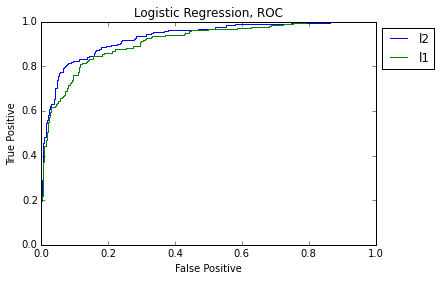

In [119]:
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='l2')
roc_curve('Logistic Regression, ROC', Y_test, logreg_2_predicted, label='l1')

###сравнение RF и простой логистической регрессией 

In [198]:
rf_5000_matrix = get_after_rf_matrix(matrix_counts, matrix_counts_bin, N_POS_TEXTS, N_NEG_TEXTS, 4400)
X_train, X_test, Y_train, Y_test = cross_valid(rf_5000_matrix, target)
logreg_3_predicted = logistic_reg(X_train, X_test, Y_train)

###Графики для RF

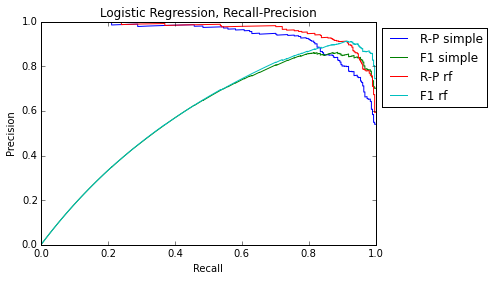

In [199]:
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_3_predicted, label='rf')

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( rf ) AUC =  0.963451787938


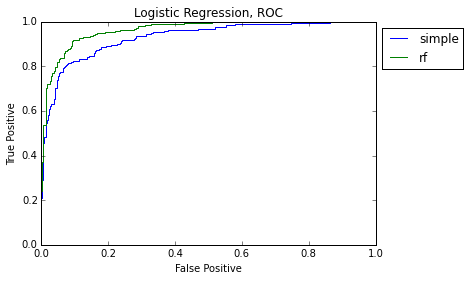

In [200]:
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_3_predicted, label='rf')

###Логистическая регрессия TF-IDF

In [142]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_tfidf, target)
logreg_4_predicted = logistic_reg(X_train, X_test, Y_train)

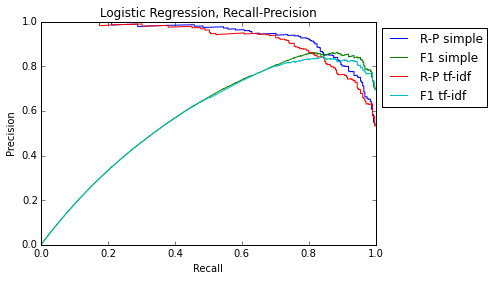

In [144]:
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_4_predicted, label='tf-idf')

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( tf-idf ) AUC =  0.91363858744


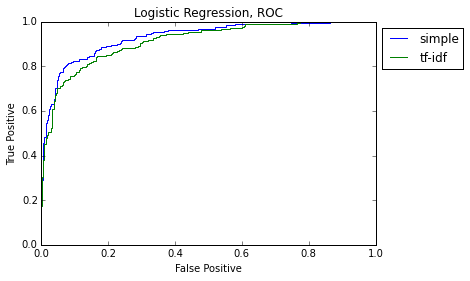

In [146]:
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_4_predicted, label='tf-idf')

In [192]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_without_stopwords, target)
logreg_5_predicted = logistic_reg(X_train, X_test, Y_train)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_with_lemm, target)
logreg_6_predicted = logistic_reg(X_train, X_test, Y_train)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_with_lemm_without_stopwords, target)
logreg_7_predicted = logistic_reg(X_train, X_test, Y_train)

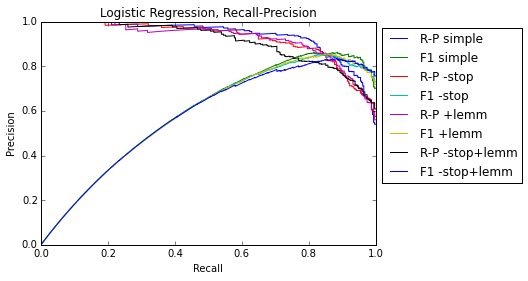

In [193]:
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_1_predicted, label='simple')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_5_predicted, label='-stop')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_6_predicted, label='+lemm')
rp_curve('Logistic Regression, Recall-Precision', Y_test, logreg_7_predicted, label='-stop+lemm')

Logistic Regression ( simple ) AUC =  0.931306706992
Logistic Regression ( -stop ) AUC =  0.917152197118
Logistic Regression ( +lemm ) AUC =  0.917841576232
Logistic Regression ( -stop+lemm ) AUC =  0.905010229497


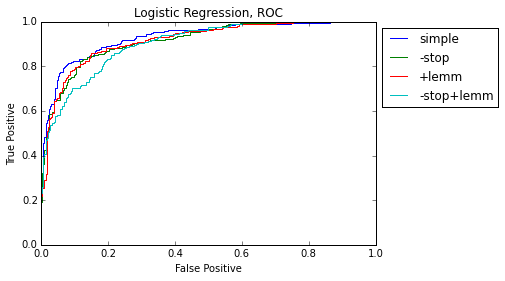

In [204]:
roc_curve('Logistic Regression, ROC', Y_test, logreg_1_predicted, label='simple')
roc_curve('Logistic Regression, ROC', Y_test, logreg_5_predicted, label='-stop')
roc_curve('Logistic Regression, ROC', Y_test, logreg_6_predicted, label='+lemm')
roc_curve('Logistic Regression, ROC', Y_test, logreg_7_predicted, label='-stop+lemm')

In [202]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
model_rfc = RandomForestClassifier(n_estimators=30)
model_rfc.fit(X_train, Y_train)

predicted = model_rfc.predict_proba(X_test)

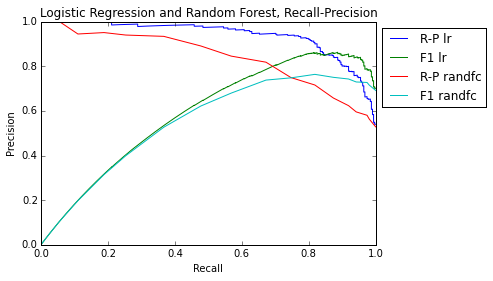

In [203]:
rp_curve('Logistic Regression and Random Forest, Recall-Precision', Y_test, logreg_1_predicted, label='lr')
rp_curve('Logistic Regression and Random Forest, Recall-Precision', Y_test, predicted, label='rfc')

Logistic Regression ( lr ) AUC =  0.931306706992
Logistic Regression ( randfc ) AUC =  0.825564846113


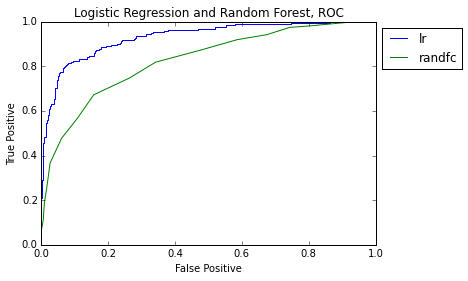

In [206]:
roc_curve('Logistic Regression and Random Forest, ROC', Y_test, logreg_1_predicted, label='lr')
roc_curve('Logistic Regression and Random Forest, ROC', Y_test, predicted, label='randfc')

In [208]:
from sklearn import svm

clf = svm.SVC(probability=True)
X_train, X_test, Y_train, Y_test = train_test_split(matrix_counts, target, test_size=0.3, random_state=0)
clf.fit(X_train, Y_train)
predicted = clf.predict_proba(X_test)

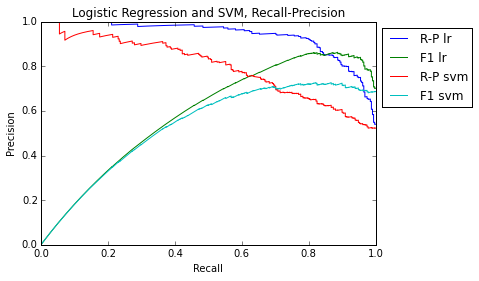

In [209]:
rp_curve('Logistic Regression and SVM, Recall-Precision', Y_test, logreg_1_predicted, label='lr')
rp_curve('Logistic Regression and SVM, Recall-Precision', Y_test, predicted, label='svm')

Logistic Regression ( lr ) AUC =  0.931306706992
Logistic Regression ( svm ) AUC =  0.77298856965


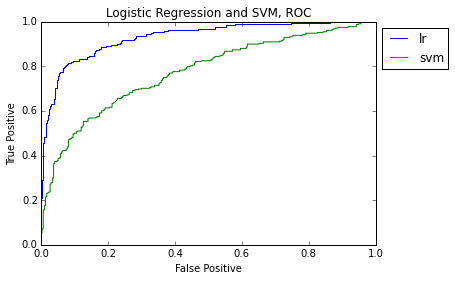

In [210]:
roc_curve('Logistic Regression and SVM', Y_test, logreg_1_predicted, label='lr')
roc_curve('Logistic Regression and SVM, ROC', Y_test, predicted, label='svm')

In [211]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
X_train, X_test, Y_train, Y_test = train_test_split(matrix_counts, target, test_size=0.3, random_state=0)
gnb.fit(X_train, Y_train)
gnb_predicted = gnb.predict_proba(X_test)
mnb.fit(X_train, Y_train)
mnb_predicted = mnb.predict_proba(X_test)
bnb.fit(X_train, Y_train)
bnb_predicted = bnb.predict_proba(X_test)

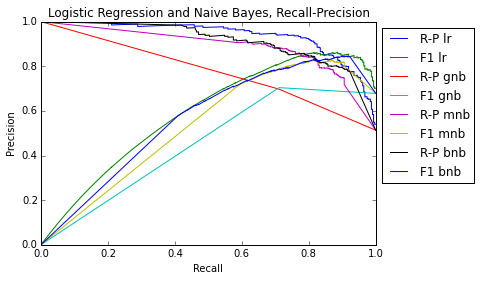

In [212]:
rp_curve('Logistic Regression and Naive Bayes, Recall-Precision', Y_test, logreg_1_predicted, label='lr')
rp_curve('Logistic Regression and Naive Bayes, Recall-Precision', Y_test, gnb_predicted, label='gnb')
rp_curve('Logistic Regression and Naive Bayes, Recall-Precision', Y_test, mnb_predicted, label='mnb')
rp_curve('Logistic Regression and Naive Bayes, Recall-Precision', Y_test, bnb_predicted, label='bnb')

Logistic Regression ( lr ) AUC =  0.931306706992
Logistic Regression ( gnb ) AUC =  0.692848247643
Logistic Regression ( mnb ) AUC =  0.869935287315
Logistic Regression ( bnb ) AUC =  0.896409669098


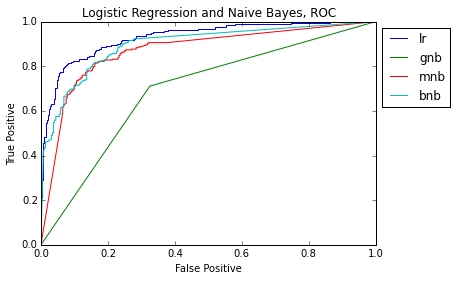

In [213]:
roc_curve('Logistic Regression and Naive Bayes, ROC', Y_test, logreg_1_predicted, label='lr')
roc_curve('Logistic Regression and Naive Bayes, ROC', Y_test, gnb_predicted, label='gnb')
roc_curve('Logistic Regression and Naive Bayes, ROC', Y_test, mnb_predicted, label='mnb')
roc_curve('Logistic Regression and Naive Bayes, ROC', Y_test, bnb_predicted, label='bnb')